# NUS FinTech Credit Card Fraud Detection

In this notebook, we will create ML models for predicting if a particular transaction is genuine or fraudulent.
We will test our model using several metrics and choose the model with the best metric.

Below are the data sheets available for analysis.
- <b>customer.csv</b>: contains data related to the customers
- <b>train.csv/test.csv</b>: contains data related to the transactions
- <b>terminal.csv</b>: terminal/pos data

In [35]:
# Importing necessary libraries

import numpy as np
import pandas as pd
import sklearn
import seaborn as sns

In [7]:
# Take a look at the different datasets

data = pd.read_csv("train.csv")
data.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD
0,59383,2021-08-01 00:04:37,323,217,4.60,0
1,59384,2021-08-01 00:12:10,6,429,8.61,0
2,59385,2021-08-01 00:12:34,714,1011,64.00,0
3,59386,2021-08-01 00:15:40,266,1969,12.72,0
4,59387,2021-08-01 00:16:01,890,1482,98.88,0


In [3]:
customers = pd.read_csv("customer.csv")
customers.head()

,CUSTOMER_ID,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,available_terminals,nb_terminals
0,0,54.881350,71.518937,62.262521,31.131260,2.179533,"[29, 87, 144, 241, 330, 858, 996, 1028, 1067, ...",22
1,1,42.365480,64.589411,46.570785,23.285393,3.567092,"[5, 160, 242, 378, 431, 475, 571, 762, 876, 93...",20
2,2,96.366276,38.344152,80.213879,40.106939,2.115580,"[316, 406, 447, 523, 968, 1200, 1318, 1365, 16...",10
3,3,56.804456,92.559664,11.748426,5.874213,0.348517,"[65, 94, 113, 364, 401, 433, 485, 651, 672, 77...",17
4,4,2.021840,83.261985,78.924891,39.462446,3.480049,"[372, 614, 774, 1362, 1446, 1564, 1637, 1939]",8


In [4]:
terminals = pd.read_csv("terminal.csv")
terminals.head()

,TERMINAL_ID,x_terminal_id,y_terminal_id
0,0,41.702200,72.032449
1,1,0.011437,30.233257
2,2,14.675589,9.233859
3,3,18.626021,34.556073
4,4,39.676747,53.881673


Since there is no linearity associated with the data for predicting the outcome, we will disregard the linear classification models and only concentrate on other classification models.
Here, we will try the below models
- Random Forest
- Naive Bayes
- SVM

We will also use the clustering algorithm for using it in our data.

## Exploratory Data Analysis

In [16]:
data.TX_DATETIME = pd.to_datetime(data.TX_DATETIME)
data.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD
0,59383,2021-08-01 00:04:37,323,217,4.60,0
1,59384,2021-08-01 00:12:10,6,429,8.61,0
2,59385,2021-08-01 00:12:34,714,1011,64.00,0
3,59386,2021-08-01 00:15:40,266,1969,12.72,0
4,59387,2021-08-01 00:16:01,890,1482,98.88,0


In [27]:
# Checking the fraudulent transactions for finding patterns

fraudulent_transactions = data[data.TX_FRAUD == 1]
fraudulent_transactions.head(20)

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD
8,59391,2021-08-01 00:32:04,220,828,76.25,1
268,59651,2021-08-01 06:29:19,74,531,228.58,1
327,59710,2021-08-01 07:01:39,580,1084,71.79,1
346,59729,2021-08-01 07:16:18,975,423,36.26,1
413,59796,2021-08-01 07:48:07,679,1893,38.80,1
462,59845,2021-08-01 08:17:32,672,207,73.26,1
498,59881,2021-08-01 08:35:37,438,828,4.05,1
533,59916,2021-08-01 08:51:34,179,115,75.65,1
576,59959,2021-08-01 09:09:58,558,894,57.72,1
628,60011,2021-08-01 09:38:55,975,28,34.85,1


<Axes: ylabel='Frequency'>

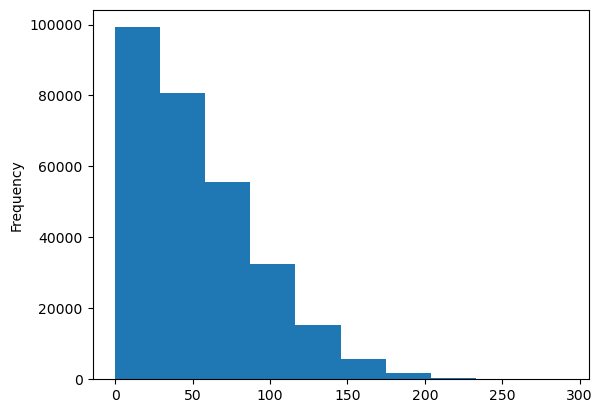

In [34]:
# Checking for distribution of transaction amounts
data.TX_AMOUNT.plot(kind='hist')
#fraudulent_transactions.TX_AMOUNT.plot(kind='hist')

<Axes: ylabel='Frequency'>

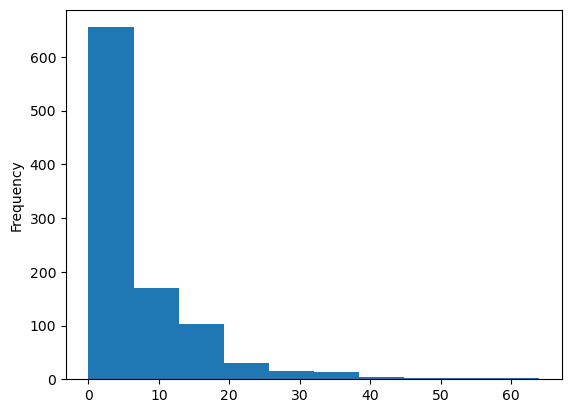

In [39]:
data.groupby('CUSTOMER_ID').agg({'TX_AMOUNT': 'max', 'TRANSACTION_ID': 'count', 'TX_FRAUD': 'sum'}).sort_values(by='TX_FRAUD', ascending=False).TX_FRAUD.plot(kind='hist')

In [9]:
# Number of Genuine and fake transactions

counts = data.value_counts("TX_FRAUD")
counts

TX_FRAUD
0    284649
1      6582
Name: count, dtype: int64

We can observe that there is huge imbalance in the dataset, because there are lot of genuine transactions and very less number of fraudulent transactions. To address this imbalance, we need to use certain techniques to increase the prediction power.

<u>Some of these techniques are</u>:
- Undersampling of majority class
- Oversampling of minority class
- Synthetic oversampling
- Use appropriate ML algos
- Use loss function which penalizes the misclassification of mibority class more
- Use anomaly detection strategy

### Undersampling of majority class

Since there are very less number of data available, we will not try this method.

### Oversampling of minority class

### Synthetic oversampling

### Use appropriate ML algos

### Use loss function which penalizes the misclassification of mibority class more

### Use anomaly detection strategy